# Solution for Overpaid Taxes

## Problem Understanding
Ask:

Develop a data science-based solution to optimize Deloitte Tax's process of identifying and refunding overpaid taxes for their clients. Analyze existing data from the client's accounts payable system to discover potential areas of improvement and create a model to streamline the process. Apply the data science process (attached) to historical client project data and present your findings and model to the Deloitte Tax team.

Context:

Clients provide 4 years’ worth of export data from their accounts payable system. This covers all areas of their business spending, and can cover multiple different tax jurisdictions. Each jurisdiction can have their own way to treat the taxability for the same items. The main output of the work Deloitte teams do currently are determinations for taxability, which can be ‘taxable’ and ‘non-taxable’. Once this determination is made, overpayments are found by finding when taxes have been paid for transactions that are ‘non-taxable’. This field is labeled “Taxability.STATE.Status” Clients want to understand why determinations are made so that their tax software can be updated to address mistakes previously made. Incorporate this need into the type and complexity of the model selected.

Insight:

The clients ask presents a  binary classifictaion problem between the two classes of 'taxable' and 'non-taxable' status, as determined in our target variable for this dataset, “Taxability.STATE.Status”.

## Import libraries and load data

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
from ydata_profiling import ProfileReport
from sklearn.model_selection import train_test_split, RandomizedSearchCV, StratifiedKFold
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder, RobustScaler, StandardScaler
from sklearn import metrics
from sklearn.metrics import mean_squared_error,confusion_matrix
from sklearn.metrics import auc,roc_curve, accuracy_score, classification_report
from sklearn.model_selection import cross_val_score
from sklearn.linear_model import LogisticRegression
from sklearn import model_selection
from category_encoders import HashingEncoder
import matplotlib.pyplot as plt
%matplotlib inline
import warnings
from sklearn.impute import SimpleImputer
from sklearn.ensemble import RandomForestClassifier

In [2]:
# load data
data = pd.read_csv('KP_NV19_SUM_and_Details_Separate-Working_Summ_with totals.csv')

/var/folders/cz/dztysmpn7sgfqcz6vr1t0vs00000gp/T/ipykernel_41762/160620043.py:2: DtypeWarning: Columns (3) have mixed types. Specify dtype option on import or set low_memory=False.
  data = pd.read_csv('KP_NV19_SUM_and_Details_Separate-Working_Summ_with totals.csv')


In [3]:
data.head()

,Invoice.ParentCompanyCode,Invoice.CompanyCode,Invoice.VendorName,Invoice.VendorCode,Invoice.Date,Invoice.Number,Invoice.Sequence,Line.Number,Line.CostCenterCode,Line.GLMainAccountNumber,...,Taxability.STATE.OutOfStatuteDate,Taxability.Mode,Taxability.STATE.Status,Taxability.STATE.ReviewStatus,Taxability.STATE.Confidence,Invoice.Note.text,Invoice.VoucherCode,"@CustomField(Invoice,PotentialTaxDue,Invoice,DOUBLE)","@CustomField(Invoice,CalculatedTax,Invoice,DOUBLE)","@CustomField(Invoice,TaxabilityClassification,Invoice,STRING)"
0,201,NORTHERN CA HOSPITAL,W W GRAINGER INC,100008941,11/1/19,22768,1,1,4450-Prop/Fac-Facilities Svcs,76999,...,1/31/23,INVOICE,TAXABLE,OUTSTANDING,99.99,00000000-ALL ITEMS,22768,0.0,2.44,NO_ERROR
1,201,NORTHERN CA HOSPITAL,W W GRAINGER INC,100008941,11/1/19,22767,1,1,4450-Prop/Fac-Facilities Svcs,76999,...,1/31/23,INVOICE,TAXABLE,OUTSTANDING,99.99,00000000-ALL ITEMS,22767,0.0,3.14,NO_ERROR
2,201,NORTHERN CA HOSPITAL,W W GRAINGER INC,100008941,11/1/19,22773,1,1,0279-Hosp Svcs - Epidemic,76999,...,1/31/23,INVOICE,TAXABLE,OUTSTANDING,99.99,00000000-ALL ITEMS,22773,0.0,84.94,NO_ERROR
3,201,NORTHERN CA HOSPITAL,W W GRAINGER INC,100008941,11/1/19,22771,1,1,4450-Prop/Fac-Facilities Svcs,76999,...,1/31/23,INVOICE,TAXABLE,OUTSTANDING,99.99,00000000-ALL ITEMS,22771,0.0,0.87,NO_ERROR
4,201,NORTHERN CA HOSPITAL,W W GRAINGER INC,100008941,11/1/19,22779,1,1,0308-Outpatient Surgery- 1,76999,...,1/31/23,INVOICE,TAXABLE,OUTSTANDING,99.98,00000000-ALL ITEMS,22779,0.0,2.91,NO_ERROR


In [4]:
data['@CustomField(Invoice,TaxabilityClassification,Invoice,STRING)']

0             NO_ERROR
1             NO_ERROR
2             NO_ERROR
3             NO_ERROR
4             NO_ERROR
              ...     
224655       LIABILITY
224656       LIABILITY
224657       LIABILITY
224658       LIABILITY
224659    UNDETERMINED
Name: @CustomField(Invoice,TaxabilityClassification,Invoice,STRING), Length: 224660, dtype: object

## Exploratory Data Analysis (EDA)

In [5]:
# Dataframe shape
print('Dataframe shape:')
print(data.shape)

Dataframe shape:
(224660, 35)


This dataframe contains 4457 rows and 61 columns

### Univariate Analysis

In [6]:
# Basic info
print('Basic Info:')
print(data.info())
print(' ')

Basic Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 224660 entries, 0 to 224659
Data columns (total 35 columns):
 #   Column                                                         Non-Null Count   Dtype  
---  ------                                                         --------------   -----  
 0   Invoice.ParentCompanyCode                                      224660 non-null  int64  
 1   Invoice.CompanyCode                                            224660 non-null  object 
 2   Invoice.VendorName                                             224660 non-null  object 
 3   Invoice.VendorCode                                             224660 non-null  object 
 4   Invoice.Date                                                   224660 non-null  object 
 5   Invoice.Number                                                 224660 non-null  int64  
 6   Invoice.Sequence                                               224660 non-null  int64  
 7   Line.Number                        

In Basic Info, all dataframe feature column names are listed. There are three data types in this dataset: object, float64, and int64, therefore we have both numerical and categorical data in this dataframe. Several columns are empty and have no entries at all. Here, only three features:

 'Taxability.STATE.Exemption.CategoryCode'
 
 'Invoice.VendorCode'
 
 'Invoice.VendorName'
 
are identified as having missing data producing null values. However as we will come to find later that identifictaion of null values is in fact decpetive.

In [7]:
data['Taxability.STATE.Status']

0              TAXABLE
1              TAXABLE
2              TAXABLE
3              TAXABLE
4              TAXABLE
              ...     
224655         TAXABLE
224656         TAXABLE
224657         TAXABLE
224658         TAXABLE
224659    UNDETERMINED
Name: Taxability.STATE.Status, Length: 224660, dtype: object

This categorical feature is our target variable and gives us the determination for taxability as either 'TAXABLE' or 'NONTAXABLE' .

In [8]:
data.isnull().sum(axis=0)

Invoice.ParentCompanyCode                                           0
Invoice.CompanyCode                                                 0
Invoice.VendorName                                                  0
Invoice.VendorCode                                                  0
Invoice.Date                                                        0
Invoice.Number                                                      0
Invoice.Sequence                                                    0
Line.Number                                                         0
Line.CostCenterCode                                                 0
Line.GLMainAccountNumber                                            0
Line.GLSubAccountNumber                                             0
Line.GLAccountDescription                                           0
Invoice.Description                                                 0
Line.ItemDescription                                                0
Invoice.GrossValue  

In [9]:
list(zip(data.columns, data.nunique()))

[('Invoice.ParentCompanyCode', 26),
 ('Invoice.CompanyCode', 26),
 ('Invoice.VendorName', 2298),
 ('Invoice.VendorCode', 3038),
 ('Invoice.Date', 1),
 ('Invoice.Number', 224660),
 ('Invoice.Sequence', 1),
 ('Line.Number', 1),
 ('Line.CostCenterCode', 1549),
 ('Line.GLMainAccountNumber', 222),
 ('Line.GLSubAccountNumber', 8),
 ('Line.GLAccountDescription', 221),
 ('Invoice.Description', 76913),
 ('Line.ItemDescription', 76913),
 ('Invoice.GrossValue', 60512),
 ('Invoice.SalesTaxPaid', 22609),
 ('Invoice.UseTax', 9535),
 ('Invoice.NetValue', 74395),
 ('Line.GrossValue', 60512),
 ('Line.SalesTaxPaid', 22609),
 ('Line.UseTax', 9535),
 ('Line.NetValue', 74395),
 ('Invoice.PaymentReference', 224660),
 ('Taxability.STATE.JurisdictionCode', 11),
 ('Taxability.STATE.JurisdictionDescription', 11),
 ('Taxability.STATE.OutOfStatuteDate', 5),
 ('Taxability.Mode', 1),
 ('Taxability.STATE.Status', 3),
 ('Taxability.STATE.ReviewStatus', 2),
 ('Taxability.STATE.Confidence', 2911),
 ('Invoice.Note.text'

In [10]:
data['Line.GLAccountDescription']

0         Other Non-Medical Supplies
1         Other Non-Medical Supplies
2         Other Non-Medical Supplies
3         Other Non-Medical Supplies
4         Other Non-Medical Supplies
                     ...            
224655        CIP-Moveable Equipment
224656        CIP-Moveable Equipment
224657        CIP-Moveable Equipment
224658        CIP-Moveable Equipment
224659        CIP-Moveable Equipment
Name: Line.GLAccountDescription, Length: 224660, dtype: object

In [11]:
data_final = data

In [12]:
data_final.head()

,Invoice.ParentCompanyCode,Invoice.CompanyCode,Invoice.VendorName,Invoice.VendorCode,Invoice.Date,Invoice.Number,Invoice.Sequence,Line.Number,Line.CostCenterCode,Line.GLMainAccountNumber,...,Taxability.STATE.OutOfStatuteDate,Taxability.Mode,Taxability.STATE.Status,Taxability.STATE.ReviewStatus,Taxability.STATE.Confidence,Invoice.Note.text,Invoice.VoucherCode,"@CustomField(Invoice,PotentialTaxDue,Invoice,DOUBLE)","@CustomField(Invoice,CalculatedTax,Invoice,DOUBLE)","@CustomField(Invoice,TaxabilityClassification,Invoice,STRING)"
0,201,NORTHERN CA HOSPITAL,W W GRAINGER INC,100008941,11/1/19,22768,1,1,4450-Prop/Fac-Facilities Svcs,76999,...,1/31/23,INVOICE,TAXABLE,OUTSTANDING,99.99,00000000-ALL ITEMS,22768,0.0,2.44,NO_ERROR
1,201,NORTHERN CA HOSPITAL,W W GRAINGER INC,100008941,11/1/19,22767,1,1,4450-Prop/Fac-Facilities Svcs,76999,...,1/31/23,INVOICE,TAXABLE,OUTSTANDING,99.99,00000000-ALL ITEMS,22767,0.0,3.14,NO_ERROR
2,201,NORTHERN CA HOSPITAL,W W GRAINGER INC,100008941,11/1/19,22773,1,1,0279-Hosp Svcs - Epidemic,76999,...,1/31/23,INVOICE,TAXABLE,OUTSTANDING,99.99,00000000-ALL ITEMS,22773,0.0,84.94,NO_ERROR
3,201,NORTHERN CA HOSPITAL,W W GRAINGER INC,100008941,11/1/19,22771,1,1,4450-Prop/Fac-Facilities Svcs,76999,...,1/31/23,INVOICE,TAXABLE,OUTSTANDING,99.99,00000000-ALL ITEMS,22771,0.0,0.87,NO_ERROR
4,201,NORTHERN CA HOSPITAL,W W GRAINGER INC,100008941,11/1/19,22779,1,1,0308-Outpatient Surgery- 1,76999,...,1/31/23,INVOICE,TAXABLE,OUTSTANDING,99.98,00000000-ALL ITEMS,22779,0.0,2.91,NO_ERROR


In [13]:
X = data
X = X.dropna(subset=['@CustomField(Invoice,PotentialTaxDue,Invoice,DOUBLE)'])

In [14]:
y = X['Taxability.STATE.Status']
X = X.drop(['Taxability.STATE.Status'], axis =1)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.40, random_state = 42)

In [15]:

X_train.drop('Invoice.Number', axis=1,inplace=True)
X_train.drop('Invoice.VoucherCode', axis=1,inplace=True)
X_train.drop('Invoice.PaymentReference', axis=1,inplace=True)
X_train.drop('Taxability.Mode', axis=1,inplace=True)
X_train.drop('Line.Number', axis=1,inplace=True)
X_train.drop('Invoice.Sequence', axis=1,inplace=True)
X_train.drop('Invoice.Date', axis=1,inplace=True)
X_train.drop("Line.GrossValue",axis=1,inplace=True)
X_train.drop("Line.SalesTaxPaid",axis=1,inplace=True)
X_train.drop("Line.UseTax",axis=1,inplace=True)
X_train.drop("Line.NetValue",axis=1,inplace=True)
X_train.drop("Line.ItemDescription",axis=1,inplace=True)
X_train.drop('Line.GLSubAccountNumber', axis=1,inplace=True)
X_train.drop('Invoice.Note.text', axis=1,inplace=True)
X_train.drop('Taxability.STATE.JurisdictionDescription', axis=1,inplace=True)
X_train.drop('Invoice.VendorName',axis=1,inplace=True)
X_train.drop('Invoice.VendorCode',axis=1,inplace=True)
X_train.drop('Line.CostCenterCode',axis=1,inplace=True)
X_train.drop('Invoice.CompanyCode',axis=1,inplace=True)
X_train.drop('Line.GLMainAccountNumber',axis=1,inplace=True)
X_train.drop("Invoice.ParentCompanyCode",axis=1,inplace=True)

X_train.info()
print('data_final dimensions: ')
print(X_train.shape)

<class 'pandas.core.frame.DataFrame'>
Int64Index: 132208 entries, 121689 to 123235
Data columns (total 13 columns):
 #   Column                                                         Non-Null Count   Dtype  
---  ------                                                         --------------   -----  
 0   Line.GLAccountDescription                                      132208 non-null  object 
 1   Invoice.Description                                            132208 non-null  object 
 2   Invoice.GrossValue                                             132208 non-null  float64
 3   Invoice.SalesTaxPaid                                           132208 non-null  float64
 4   Invoice.UseTax                                                 132208 non-null  float64
 5   Invoice.NetValue                                               132208 non-null  float64
 6   Taxability.STATE.JurisdictionCode                              132208 non-null  object 
 7   Taxability.STATE.OutOfStatuteDate         

In [16]:
X_train = X_train.replace(to_replace='N.A',value=np.nan)

In [17]:
X_train.isna().sum()

Line.GLAccountDescription                                        10
Invoice.Description                                               0
Invoice.GrossValue                                                0
Invoice.SalesTaxPaid                                              0
Invoice.UseTax                                                    0
Invoice.NetValue                                                  0
Taxability.STATE.JurisdictionCode                                 4
Taxability.STATE.OutOfStatuteDate                                79
Taxability.STATE.ReviewStatus                                     0
Taxability.STATE.Confidence                                       0
@CustomField(Invoice,PotentialTaxDue,Invoice,DOUBLE)              0
@CustomField(Invoice,CalculatedTax,Invoice,DOUBLE)                0
@CustomField(Invoice,TaxabilityClassification,Invoice,STRING)     0
dtype: int64

In [18]:
X_train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 132208 entries, 121689 to 123235
Data columns (total 13 columns):
 #   Column                                                         Non-Null Count   Dtype  
---  ------                                                         --------------   -----  
 0   Line.GLAccountDescription                                      132198 non-null  object 
 1   Invoice.Description                                            132208 non-null  object 
 2   Invoice.GrossValue                                             132208 non-null  float64
 3   Invoice.SalesTaxPaid                                           132208 non-null  float64
 4   Invoice.UseTax                                                 132208 non-null  float64
 5   Invoice.NetValue                                               132208 non-null  float64
 6   Taxability.STATE.JurisdictionCode                              132204 non-null  object 
 7   Taxability.STATE.OutOfStatuteDate         

In [19]:
list(zip(X_train.columns, X_train.nunique()))

[('Line.GLAccountDescription', 204),
 ('Invoice.Description', 52493),
 ('Invoice.GrossValue', 43861),
 ('Invoice.SalesTaxPaid', 17035),
 ('Invoice.UseTax', 7034),
 ('Invoice.NetValue', 53248),
 ('Taxability.STATE.JurisdictionCode', 10),
 ('Taxability.STATE.OutOfStatuteDate', 5),
 ('Taxability.STATE.ReviewStatus', 2),
 ('Taxability.STATE.Confidence', 2682),
 ('@CustomField(Invoice,PotentialTaxDue,Invoice,DOUBLE)', 6379),
 ('@CustomField(Invoice,CalculatedTax,Invoice,DOUBLE)', 17035),
 ('@CustomField(Invoice,TaxabilityClassification,Invoice,STRING)', 3)]

In [20]:
X_train['Taxability.STATE.ReviewStatus'].value_counts()

APPROVED       78281
OUTSTANDING    53927
Name: Taxability.STATE.ReviewStatus, dtype: int64

In [21]:
X_train['@CustomField(Invoice,TaxabilityClassification,Invoice,STRING)'].value_counts()

NO_ERROR     104839
REFUND        23138
LIABILITY      4231
Name: @CustomField(Invoice,TaxabilityClassification,Invoice,STRING), dtype: int64

In [22]:
y_train.value_counts()

TAXABLE       109066
NONTAXABLE     23142
Name: Taxability.STATE.Status, dtype: int64

In [23]:
X_train['Taxability.STATE.Confidence'].value_counts()

100.00    78281
99.99     28645
99.98      1685
99.97      1113
99.96       791
          ...  
83.94         1
72.61         1
74.97         1
91.57         1
76.81         1
Name: Taxability.STATE.Confidence, Length: 2682, dtype: int64

In [24]:
#scaled = X_train[['Invoice.GrossValue','Invoice.SalesTaxPaid', 'Invoice.UseTax', 'Invoice.NetValue', 'Taxability.STATE.Confidence', '@CustomField(Invoice,PotentialTaxDue,Invoice,DOUBLE)', '@CustomField(Invoice,CalculatedTax,Invoice,DOUBLE)']]
#cols = ['Invoice.GrossValue','Invoice.SalesTaxPaid', 'Invoice.UseTax', 'Invoice.NetValue', 'Taxability.STATE.Confidence',
#        '@CustomField(Invoice,PotentialTaxDue,Invoice,DOUBLE)', '@CustomField(Invoice,CalculatedTax,Invoice,DOUBLE)',
#]

#scaler = StandardScaler()
#ro_scaler = scaler.fit_transform(scaled)
#ro_scaler = pd.DataFrame(ro_scaler, columns = cols)


In [25]:
#ro_scaler

In [33]:
X_train_final = X_train
#X_train_final.drop('Invoice.GrossValue', axis=1, inplace=True)
#X_train_final.drop('Invoice.SalesTaxPaid', axis=1, inplace=True)
#X_train_final.drop('Invoice.UseTax', axis=1, inplace=True)
#X_train_final.drop('Invoice.NetValue', axis=1, inplace=True) 
#X_train_final.drop('Taxability.STATE.Confidence', axis=1, inplace=True)
#X_train_final.drop('@CustomField(Invoice,PotentialTaxDue,Invoice,DOUBLE)', axis=1, inplace=True)
#X_train_final.drop('@CustomField(Invoice,CalculatedTax,Invoice,DOUBLE)', axis=1, inplace=True)

In [27]:
#print(X_train_final.shape)
#print(ro_scaler.shape)

In [28]:
#X_train_final = pd.concat([X_train_final.reset_index(), ro_scaler.reset_index()], axis=1)

In [29]:
#X_train_final.shape

In [30]:
#X_train_final.drop('index', axis=1, inplace =True)

In [34]:
X_train_final.isnull().sum()

Line.GLAccountDescription                                        10
Invoice.Description                                               0
Invoice.GrossValue                                                0
Invoice.SalesTaxPaid                                              0
Invoice.UseTax                                                    0
Invoice.NetValue                                                  0
Taxability.STATE.JurisdictionCode                                 4
Taxability.STATE.OutOfStatuteDate                                79
Taxability.STATE.ReviewStatus                                     0
Taxability.STATE.Confidence                                       0
@CustomField(Invoice,PotentialTaxDue,Invoice,DOUBLE)              0
@CustomField(Invoice,CalculatedTax,Invoice,DOUBLE)                0
@CustomField(Invoice,TaxabilityClassification,Invoice,STRING)     0
dtype: int64

In [35]:
colnames = ['Line.GLAccountDescription', 'Taxability.STATE.JurisdictionCode', 'Taxability.STATE.OutOfStatuteDate']
feat = X_train_final[['Line.GLAccountDescription', 'Taxability.STATE.JurisdictionCode', 'Taxability.STATE.OutOfStatuteDate']]
imputer = SimpleImputer(strategy ='most_frequent')
imputer.fit(feat)

feats = imputer.transform(feat)
feats = pd.DataFrame(feats, columns = colnames)
feats['Taxability.STATE.ReviewStatus'] = X_train_final['Taxability.STATE.ReviewStatus']
feats['@CustomField(Invoice,TaxabilityClassification,Invoice,STRING)'] = X_train_final['@CustomField(Invoice,TaxabilityClassification,Invoice,STRING)']

In [36]:
feats

,Line.GLAccountDescription,Taxability.STATE.JurisdictionCode,Taxability.STATE.OutOfStatuteDate,Taxability.STATE.ReviewStatus,"@CustomField(Invoice,TaxabilityClassification,Invoice,STRING)"
0,Other Non-Medical Supplies,CA,1/31/23,NaN,NaN
1,Medical/Surgical Instruments,CA,1/31/23,OUTSTANDING,NO_ERROR
2,Surgical Supplies,CA,1/31/23,OUTSTANDING,NO_ERROR
3,Respiratory Supplies,WA,1/20/24,OUTSTANDING,NO_ERROR
4,Medical Gloves,CA,1/31/23,NaN,NaN
...,...,...,...,...,...
132203,AP Inventory Clring-Non Contro,CA,1/31/23,OUTSTANDING,NO_ERROR
132204,Medical/Surgical Instruments,CA,1/31/23,NaN,NaN
132205,Office Supplies,CA,1/31/23,NaN,NaN
132206,Needles & Syringes,CA,1/31/23,NaN,NaN


In [37]:
new_feats = pd.get_dummies(feats, columns = ['Taxability.STATE.JurisdictionCode', 'Taxability.STATE.OutOfStatuteDate', 'Taxability.STATE.ReviewStatus', '@CustomField(Invoice,TaxabilityClassification,Invoice,STRING)'])

In [38]:
new_feats.drop('Taxability.STATE.ReviewStatus_OUTSTANDING', axis=1, inplace=True)

In [39]:
X_train_final.drop('Line.GLAccountDescription', axis=1, inplace=True)
X_train_final.drop('Taxability.STATE.JurisdictionCode', axis=1, inplace=True)
X_train_final.drop('Taxability.STATE.OutOfStatuteDate', axis=1, inplace=True)
X_train_final.drop('Taxability.STATE.ReviewStatus', axis=1, inplace=True)
X_train_final.drop('@CustomField(Invoice,TaxabilityClassification,Invoice,STRING)', axis=1, inplace=True)

In [40]:
X_train_final = pd.concat([new_feats.reset_index(), X_train_final.reset_index()], axis=1)

In [41]:
X_train_final.drop('index', axis=1, inplace=True)

In [42]:
X_train_final.isna().sum()

Line.GLAccountDescription                                                  0
Taxability.STATE.JurisdictionCode_CA                                       0
Taxability.STATE.JurisdictionCode_CO                                       0
Taxability.STATE.JurisdictionCode_CT                                       0
Taxability.STATE.JurisdictionCode_DC                                       0
Taxability.STATE.JurisdictionCode_GA                                       0
Taxability.STATE.JurisdictionCode_HI                                       0
Taxability.STATE.JurisdictionCode_MD                                       0
Taxability.STATE.JurisdictionCode_OR                                       0
Taxability.STATE.JurisdictionCode_VA                                       0
Taxability.STATE.JurisdictionCode_WA                                       0
Taxability.STATE.OutOfStatuteDate_1/20/23                                  0
Taxability.STATE.OutOfStatuteDate_1/20/24                                  0

In [43]:
X_train_final.shape

(132208, 28)

In [44]:
hashenc1 = HashingEncoder(cols = ['Invoice.Description'],
                         n_components=16)
hash_res1 = hashenc1.fit_transform(X_train_final['Invoice.Description'])
hash_res1.sample(5)

,col_0,col_1,col_2,col_3,col_4,col_5,col_6,col_7,col_8,col_9,col_10,col_11,col_12,col_13,col_14,col_15
19021,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0
104123,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0
54572,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0
9172,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0
68342,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0


In [45]:
hash_res1.shape

(132208, 16)

In [46]:
X_train_final = pd.concat([hash_res1.reset_index(), X_train_final.reset_index()], axis=1)
X_train_final.drop('Invoice.Description', axis=1, inplace=True)
X_train_final.drop('index', axis=1, inplace=True)
X_train_final

,col_0,col_1,col_2,col_3,col_4,col_5,col_6,col_7,col_8,col_9,...,"@CustomField(Invoice,TaxabilityClassification,Invoice,STRING)_LIABILITY","@CustomField(Invoice,TaxabilityClassification,Invoice,STRING)_NO_ERROR","@CustomField(Invoice,TaxabilityClassification,Invoice,STRING)_REFUND",Invoice.GrossValue,Invoice.SalesTaxPaid,Invoice.UseTax,Invoice.NetValue,Taxability.STATE.Confidence,"@CustomField(Invoice,PotentialTaxDue,Invoice,DOUBLE)","@CustomField(Invoice,CalculatedTax,Invoice,DOUBLE)"
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,472.79,42.91,17.70,533.40,100.00,0.0,60.61
1,0,0,0,0,0,0,0,0,0,0,...,0,1,0,316.69,27.71,0.00,344.40,100.00,0.0,27.71
2,0,0,0,0,0,0,0,0,0,0,...,0,1,0,373.37,37.58,2.80,413.75,100.00,0.0,40.38
3,0,0,0,0,1,0,0,0,0,0,...,0,1,0,312.00,26.21,0.00,338.21,91.80,0.0,26.21
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,17.68,1.37,0.00,19.05,100.00,0.0,1.37
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
132203,0,0,0,0,0,0,0,0,0,0,...,0,1,0,1371.68,139.39,31.03,1542.10,100.00,0.0,170.42
132204,0,0,1,0,0,0,0,0,0,0,...,0,0,0,411.84,31.92,0.00,443.76,98.14,0.0,31.92
132205,0,0,0,0,0,0,0,0,0,0,...,0,0,0,41.21,3.19,0.00,44.40,100.00,0.0,3.19
132206,0,0,0,0,0,0,0,0,0,0,...,0,0,0,2.48,0.18,0.00,2.66,100.00,0.0,0.18


In [47]:
hashenc2 = HashingEncoder(cols = ['Line.GLAccountDescription'],
                         n_components=16)
hash_res2 = hashenc2.fit_transform(X_train_final['Line.GLAccountDescription'])
hash_res2.sample(5)

,col_0,col_1,col_2,col_3,col_4,col_5,col_6,col_7,col_8,col_9,col_10,col_11,col_12,col_13,col_14,col_15
112964,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0
97352,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0
95546,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0
98131,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0
56948,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0


In [48]:
X_train_final = pd.concat([hash_res2.reset_index(), X_train_final.reset_index()], axis=1)
X_train_final.drop('Line.GLAccountDescription', axis=1, inplace=True)
#X_train_final.drop('index', axis=1, inplace=True)

X_train_final

,index,col_0,col_1,col_2,col_3,col_4,col_5,col_6,col_7,col_8,...,"@CustomField(Invoice,TaxabilityClassification,Invoice,STRING)_LIABILITY","@CustomField(Invoice,TaxabilityClassification,Invoice,STRING)_NO_ERROR","@CustomField(Invoice,TaxabilityClassification,Invoice,STRING)_REFUND",Invoice.GrossValue,Invoice.SalesTaxPaid,Invoice.UseTax,Invoice.NetValue,Taxability.STATE.Confidence,"@CustomField(Invoice,PotentialTaxDue,Invoice,DOUBLE)","@CustomField(Invoice,CalculatedTax,Invoice,DOUBLE)"
0,0,0,0,0,0,0,0,1,0,0,...,0,0,0,472.79,42.91,17.70,533.40,100.00,0.0,60.61
1,1,0,0,1,0,0,0,0,0,0,...,0,1,0,316.69,27.71,0.00,344.40,100.00,0.0,27.71
2,2,0,0,0,1,0,0,0,0,0,...,0,1,0,373.37,37.58,2.80,413.75,100.00,0.0,40.38
3,3,0,1,0,0,0,0,0,0,0,...,0,1,0,312.00,26.21,0.00,338.21,91.80,0.0,26.21
4,4,0,0,0,0,0,0,0,0,0,...,0,0,0,17.68,1.37,0.00,19.05,100.00,0.0,1.37
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
132203,132203,0,1,0,0,0,0,0,0,0,...,0,1,0,1371.68,139.39,31.03,1542.10,100.00,0.0,170.42
132204,132204,0,0,1,0,0,0,0,0,0,...,0,0,0,411.84,31.92,0.00,443.76,98.14,0.0,31.92
132205,132205,0,0,0,0,0,1,0,0,0,...,0,0,0,41.21,3.19,0.00,44.40,100.00,0.0,3.19
132206,132206,0,1,0,0,0,0,0,0,0,...,0,0,0,2.48,0.18,0.00,2.66,100.00,0.0,0.18


In [49]:
X_train_final.isna().sum()

index                                                                      0
col_0                                                                      0
col_1                                                                      0
col_2                                                                      0
col_3                                                                      0
col_4                                                                      0
col_5                                                                      0
col_6                                                                      0
col_7                                                                      0
col_8                                                                      0
col_9                                                                      0
col_10                                                                     0
col_11                                                                     0

In [50]:
y_train

121689    TAXABLE
149707    TAXABLE
121500    TAXABLE
184983    TAXABLE
67484     TAXABLE
           ...   
121156    TAXABLE
104938    TAXABLE
133368    TAXABLE
148567    TAXABLE
123235    TAXABLE
Name: Taxability.STATE.Status, Length: 132208, dtype: object

In [51]:
lrclassifier = LogisticRegression(random_state=42)
lrclassifier.fit(X_train_final, y_train)

LogisticRegression(random_state=42)

In [52]:
y_train.shape

(132208,)

In [53]:
lrclassifier.score(X_train_final, y_train)

0.9287713300254145

##### Test_set

In [54]:
X_test_final = X_test
X_test_final.drop('Invoice.Number', axis=1,inplace=True)
X_test_final.drop('Invoice.VoucherCode', axis=1,inplace=True)
X_test_final.drop('Invoice.PaymentReference', axis=1,inplace=True)
X_test_final.drop('Taxability.Mode', axis=1,inplace=True)
X_test_final.drop('Line.Number', axis=1,inplace=True)
X_test_final.drop('Invoice.Sequence', axis=1,inplace=True)
X_test_final.drop('Invoice.Date', axis=1,inplace=True)
X_test_final.drop("Line.GrossValue",axis=1,inplace=True)
X_test_final.drop("Line.SalesTaxPaid",axis=1,inplace=True)
X_test_final.drop("Line.UseTax",axis=1,inplace=True)
X_test_final.drop("Line.NetValue",axis=1,inplace=True)
X_test_final.drop("Line.ItemDescription",axis=1,inplace=True)
X_test_final.drop('Line.GLSubAccountNumber', axis=1,inplace=True)
X_test_final.drop('Invoice.Note.text', axis=1,inplace=True)
X_test_final.drop('Taxability.STATE.JurisdictionDescription', axis=1,inplace=True)
X_test_final.drop('Invoice.VendorName',axis=1,inplace=True)
X_test_final.drop('Invoice.VendorCode',axis=1,inplace=True)
X_test_final.drop('Line.CostCenterCode',axis=1,inplace=True)
X_test_final.drop('Invoice.CompanyCode',axis=1,inplace=True)
X_test_final.drop('Line.GLMainAccountNumber',axis=1,inplace=True)
X_test_final.drop("Invoice.ParentCompanyCode",axis=1,inplace=True)
X_test_final.shape

(88140, 13)

In [55]:
X_test_final = X_test_final.replace(to_replace='N.A',value=np.nan)

In [56]:
X_test_final.isna().sum()

Line.GLAccountDescription                                         5
Invoice.Description                                               0
Invoice.GrossValue                                                0
Invoice.SalesTaxPaid                                              0
Invoice.UseTax                                                    0
Invoice.NetValue                                                  0
Taxability.STATE.JurisdictionCode                                 2
Taxability.STATE.OutOfStatuteDate                                37
Taxability.STATE.ReviewStatus                                     0
Taxability.STATE.Confidence                                       0
@CustomField(Invoice,PotentialTaxDue,Invoice,DOUBLE)              0
@CustomField(Invoice,CalculatedTax,Invoice,DOUBLE)                0
@CustomField(Invoice,TaxabilityClassification,Invoice,STRING)     0
dtype: int64

In [57]:
#scaled2 = X_test_final[['Invoice.GrossValue','Invoice.SalesTaxPaid', 'Invoice.UseTax', 'Invoice.NetValue', 'Taxability.STATE.Confidence', '@CustomField(Invoice,PotentialTaxDue,Invoice,DOUBLE)', '@CustomField(Invoice,CalculatedTax,Invoice,DOUBLE)']]
#col2 = ['Invoice.GrossValue','Invoice.SalesTaxPaid', 'Invoice.UseTax', 'Invoice.NetValue', 'Taxability.STATE.Confidence',         '@CustomField(Invoice,PotentialTaxDue,Invoice,DOUBLE)', '@CustomField(Invoice,CalculatedTax,Invoice,DOUBLE)',]

#test_scaler = scaler.transform(scaled2)
#test_scaler = pd.DataFrame(test_scaler, columns = col2)

In [58]:
#test_scaler

In [59]:

#X_test_final.drop('Invoice.GrossValue', axis=1, inplace=True)
#X_test_final.drop('Invoice.SalesTaxPaid', axis=1, inplace=True)
#X_test_final.drop('Invoice.UseTax', axis=1, inplace=True)
#X_test_final.drop('Invoice.NetValue', axis=1, inplace=True) 
#X_test_final.drop('Taxability.STATE.Confidence', axis=1, inplace=True)
#X_test_final.drop('@CustomField(Invoice,PotentialTaxDue,Invoice,DOUBLE)', axis=1, inplace=True)
#X_test_final.drop('@CustomField(Invoice,CalculatedTax,Invoice,DOUBLE)', axis=1, inplace=True)

In [60]:
#X_test_final = pd.concat([X_test_final.reset_index(), test_scaler.reset_index()], axis=1)

In [61]:
#X_test_final.shape

In [62]:
#X_test_final.drop('index', axis=1, inplace =True)

In [63]:
X_test_final.shape

(88140, 13)

In [64]:
X_test_final.isna().sum()

Line.GLAccountDescription                                         5
Invoice.Description                                               0
Invoice.GrossValue                                                0
Invoice.SalesTaxPaid                                              0
Invoice.UseTax                                                    0
Invoice.NetValue                                                  0
Taxability.STATE.JurisdictionCode                                 2
Taxability.STATE.OutOfStatuteDate                                37
Taxability.STATE.ReviewStatus                                     0
Taxability.STATE.Confidence                                       0
@CustomField(Invoice,PotentialTaxDue,Invoice,DOUBLE)              0
@CustomField(Invoice,CalculatedTax,Invoice,DOUBLE)                0
@CustomField(Invoice,TaxabilityClassification,Invoice,STRING)     0
dtype: int64

In [65]:
col2names = ['Line.GLAccountDescription', 'Taxability.STATE.JurisdictionCode', 'Taxability.STATE.OutOfStatuteDate']
feat2 = X_test_final[['Line.GLAccountDescription', 'Taxability.STATE.JurisdictionCode', 'Taxability.STATE.OutOfStatuteDate']]
feat2 = imputer.transform(feat2)
feat2 = pd.DataFrame(feat2, columns = col2names)
feat2['Taxability.STATE.ReviewStatus'] = X_test_final['Taxability.STATE.ReviewStatus']
feat2['@CustomField(Invoice,TaxabilityClassification,Invoice,STRING)'] = X_test_final['@CustomField(Invoice,TaxabilityClassification,Invoice,STRING)']

In [66]:
feat2.shape

(88140, 5)

In [67]:
new_feat2 = pd.get_dummies(feat2, columns = ['Taxability.STATE.JurisdictionCode', 'Taxability.STATE.OutOfStatuteDate', 'Taxability.STATE.ReviewStatus', '@CustomField(Invoice,TaxabilityClassification,Invoice,STRING)'])

In [68]:
new_feat2.drop('Taxability.STATE.ReviewStatus_OUTSTANDING', axis=1, inplace=True)

In [69]:
X_test_final.drop('Line.GLAccountDescription', axis=1, inplace=True)
X_test_final.drop('Taxability.STATE.JurisdictionCode', axis=1, inplace=True)
X_test_final.drop('Taxability.STATE.OutOfStatuteDate', axis=1, inplace=True)
X_test_final.drop('Taxability.STATE.ReviewStatus', axis=1, inplace=True)
X_test_final.drop('@CustomField(Invoice,TaxabilityClassification,Invoice,STRING)', axis=1, inplace=True)

In [70]:
X_test_final = pd.concat([new_feat2.reset_index(), X_test_final.reset_index()], axis=1)

In [71]:
X_test_final.isna().sum()

index                                                                      0
Line.GLAccountDescription                                                  0
Taxability.STATE.JurisdictionCode_CA                                       0
Taxability.STATE.JurisdictionCode_CO                                       0
Taxability.STATE.JurisdictionCode_CT                                       0
Taxability.STATE.JurisdictionCode_DC                                       0
Taxability.STATE.JurisdictionCode_GA                                       0
Taxability.STATE.JurisdictionCode_HI                                       0
Taxability.STATE.JurisdictionCode_MD                                       0
Taxability.STATE.JurisdictionCode_OR                                       0
Taxability.STATE.JurisdictionCode_VA                                       0
Taxability.STATE.JurisdictionCode_WA                                       0
Taxability.STATE.OutOfStatuteDate_1/20/23                                  0

In [72]:
X_test_final.shape

(88140, 30)

In [73]:
# X_test_final2 = X_test_final

In [74]:
X_test_final.drop('index', axis=1, inplace=True)

In [75]:
hash_res3 = hashenc1.transform(X_test_final['Invoice.Description'])


In [76]:
X_test_final = pd.concat([hash_res3.reset_index(), X_test_final.reset_index()], axis=1)
X_test_final.drop('Invoice.Description', axis=1, inplace=True)
X_test_final.drop('index', axis=1, inplace=True)
X_test_final

,col_0,col_1,col_2,col_3,col_4,col_5,col_6,col_7,col_8,col_9,...,"@CustomField(Invoice,TaxabilityClassification,Invoice,STRING)_LIABILITY","@CustomField(Invoice,TaxabilityClassification,Invoice,STRING)_NO_ERROR","@CustomField(Invoice,TaxabilityClassification,Invoice,STRING)_REFUND",Invoice.GrossValue,Invoice.SalesTaxPaid,Invoice.UseTax,Invoice.NetValue,Taxability.STATE.Confidence,"@CustomField(Invoice,PotentialTaxDue,Invoice,DOUBLE)","@CustomField(Invoice,CalculatedTax,Invoice,DOUBLE)"
0,0,0,0,0,0,1,0,0,0,0,...,0,1,0,39.20,0.58,0.00,39.78,99.84,0.00,0.58
1,0,0,1,0,0,0,0,0,0,0,...,0,0,0,295.89,22.89,0.00,318.78,100.00,0.00,22.89
2,0,1,0,0,0,0,0,0,0,0,...,0,0,0,6.20,0.52,0.00,6.72,99.99,0.00,0.52
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,4.35,0.36,0.00,4.71,100.00,0.00,0.36
4,0,0,0,0,0,0,0,0,0,0,...,0,1,0,42.08,0.00,1.26,43.34,99.59,1.26,0.00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
88135,0,0,0,0,0,0,0,1,0,0,...,0,1,0,10.21,0.48,0.00,10.69,100.00,0.00,0.48
88136,0,0,0,0,0,0,0,1,0,0,...,0,1,0,407.60,37.70,0.00,445.30,99.99,0.00,37.70
88137,0,0,0,0,0,0,0,0,0,0,...,0,0,0,9.29,0.73,0.00,10.02,100.00,0.00,0.73
88138,0,0,0,0,0,0,0,0,0,0,...,0,0,0,12.19,1.04,0.00,13.23,100.00,0.00,1.04


In [77]:
X_test_final.isna().sum()

col_0                                                                      0
col_1                                                                      0
col_2                                                                      0
col_3                                                                      0
col_4                                                                      0
col_5                                                                      0
col_6                                                                      0
col_7                                                                      0
col_8                                                                      0
col_9                                                                      0
col_10                                                                     0
col_11                                                                     0
col_12                                                                     0

In [78]:
X_test_final.shape

(88140, 43)

In [79]:
hash_res4 = hashenc2.transform(X_test_final['Line.GLAccountDescription'])


In [80]:
X_test_final = pd.concat([hash_res2.reset_index(), X_test_final.reset_index()], axis=1)
X_test_final.drop('Line.GLAccountDescription', axis=1, inplace=True)
#X_test_final.drop('index', axis=1, inplace=True)
X_test_final

,index,col_0,col_1,col_2,col_3,col_4,col_5,col_6,col_7,col_8,...,"@CustomField(Invoice,TaxabilityClassification,Invoice,STRING)_LIABILITY","@CustomField(Invoice,TaxabilityClassification,Invoice,STRING)_NO_ERROR","@CustomField(Invoice,TaxabilityClassification,Invoice,STRING)_REFUND",Invoice.GrossValue,Invoice.SalesTaxPaid,Invoice.UseTax,Invoice.NetValue,Taxability.STATE.Confidence,"@CustomField(Invoice,PotentialTaxDue,Invoice,DOUBLE)","@CustomField(Invoice,CalculatedTax,Invoice,DOUBLE)"
0,0,0,0,0,0,0,0,1,0,0,...,0.0,1.0,0.0,39.20,0.58,0.00,39.78,99.84,0.00,0.58
1,1,0,0,1,0,0,0,0,0,0,...,0.0,0.0,0.0,295.89,22.89,0.00,318.78,100.00,0.00,22.89
2,2,0,0,0,1,0,0,0,0,0,...,0.0,0.0,0.0,6.20,0.52,0.00,6.72,99.99,0.00,0.52
3,3,0,1,0,0,0,0,0,0,0,...,0.0,0.0,0.0,4.35,0.36,0.00,4.71,100.00,0.00,0.36
4,4,0,0,0,0,0,0,0,0,0,...,0.0,1.0,0.0,42.08,0.00,1.26,43.34,99.59,1.26,0.00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
132203,132203,0,1,0,0,0,0,0,0,0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
132204,132204,0,0,1,0,0,0,0,0,0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
132205,132205,0,0,0,0,0,1,0,0,0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
132206,132206,0,1,0,0,0,0,0,0,0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [81]:
X_test_final.isna().sum()

index                                                                          0
col_0                                                                          0
col_1                                                                          0
col_2                                                                          0
col_3                                                                          0
col_4                                                                          0
col_5                                                                          0
col_6                                                                          0
col_7                                                                          0
col_8                                                                          0
col_9                                                                          0
col_10                                                                         0
col_11                      

In [82]:
X_test_final.dropna(inplace=True)

In [83]:
y_pred = lrclassifier.predict(X_test_final)

In [84]:

score = accuracy_score(y_pred, y_test)
print(score)
print(classification_report(y_pred, y_test))

0.9267415475380077
              precision    recall  f1-score   support

  NONTAXABLE       0.59      1.00      0.74      9326
     TAXABLE       1.00      0.92      0.96     78814

    accuracy                           0.93     88140
   macro avg       0.80      0.96      0.85     88140
weighted avg       0.96      0.93      0.93     88140



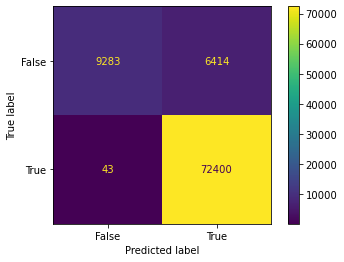

In [102]:
from sklearn.metrics import confusion_matrix, auc, roc_curve
from sklearn import metrics
import matplotlib.pyplot as plt
%matplotlib inline

cm = confusion_matrix(y_test,y_pred)
cm_display = metrics.ConfusionMatrixDisplay(confusion_matrix = cm,
                                       display_labels = [False,True])
cm_display.plot()
plt.show()

/Users/malmahdi/opt/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_ranking.py:999: UndefinedMetricWarning: No positive samples in y_true, true positive value should be meaningless
  warnings.warn(


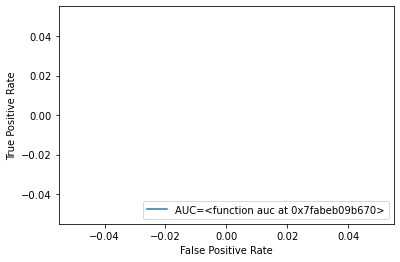

In [107]:
# define metrics
y_pred_proba = lrclassifier.predict_proba(X_test_final)[::,1]
fpr, tpr, _ = metrics.roc_curve(y_test, y_pred_proba, pos_label=1)

# create ROC curve
plt.plot(fpr,tpr,label='AUC='+str(auc))
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.legend(loc=4)
plt.show()

### Random Forest Classifier using RandomSearchCV

In [85]:
rfc = RandomForestClassifier()

# Declare rfc hyperparameters distribution
param_dist ={'n_estimators': [100,200,300,500,700,800,1000],
             'criterion': ['entropy', 'gini'],
             'min_samples_split': [2,3,4,5,7,8,9,10],
             'min_samples_leaf': [1,2,3,4,5],
             'max_features': ['sqrt', 'log2'],
             'max_depth':[1,2,3,4,5,6,7],
             'random_state': [42],
             'bootstrap': [True, False]
                    }
# Though not severe in any particular category, Because we are using a RandomForest
# classifier, we will address the several data imbalances in this dataset 
# with the ensemble method of StratifiedKFold
kf = StratifiedKFold()

# Create RandomizedSearchCV and find optimal hyperparameters for rfc
rs = RandomizedSearchCV(estimator=rfc, 
                        param_distributions=param_dist,
                        n_iter=100,
                        cv=kf,
                        scoring='accuracy',
                        n_jobs=-1,
                        verbose=2,
                   )
# Fit rs to training data
rs.fit(X_train_final, y_train)


Fitting 5 folds for each of 100 candidates, totalling 500 fits
[CV] END bootstrap=True, criterion=gini, max_depth=2, max_features=sqrt, min_samples_leaf=5, min_samples_split=5, n_estimators=800, random_state=42; total time=  19.9s
[CV] END bootstrap=True, criterion=gini, max_depth=1, max_features=log2, min_samples_leaf=2, min_samples_split=8, n_estimators=700, random_state=42; total time=  10.8s
[CV] END bootstrap=False, criterion=gini, max_depth=7, max_features=log2, min_samples_leaf=2, min_samples_split=7, n_estimators=500, random_state=42; total time=  27.2s
[CV] END bootstrap=True, criterion=gini, max_depth=5, max_features=log2, min_samples_leaf=5, min_samples_split=7, n_estimators=800, random_state=42; total time=  27.7s
[CV] END bootstrap=False, criterion=entropy, max_depth=4, max_features=log2, min_samples_leaf=5, min_samples_split=2, n_estimators=1000, random_state=42; total time=  41.1s
[CV] END bootstrap=True, criterion=entropy, max_depth=1, max_features=sqrt, min_samples_lea

RandomizedSearchCV(cv=StratifiedKFold(n_splits=5, random_state=None, shuffle=False),
                   estimator=RandomForestClassifier(), n_iter=100, n_jobs=-1,
                   param_distributions={'bootstrap': [True, False],
                                        'criterion': ['entropy', 'gini'],
                                        'max_depth': [1, 2, 3, 4, 5, 6, 7],
                                        'max_features': ['sqrt', 'log2'],
                                        'min_samples_leaf': [1, 2, 3, 4, 5],
                                        'min_samples_split': [2, 3, 4, 5, 7, 8,
                                                              9, 10],
                                        'n_estimators': [100, 200, 300, 500,
                                                         700, 800, 1000],
                                        'random_state': [42]},
                   scoring='accuracy', verbose=2)

In [93]:
best_params = rs.best_params_
best_params

{'random_state': 42,
 'n_estimators': 300,
 'min_samples_split': 2,
 'min_samples_leaf': 5,
 'max_features': 'sqrt',
 'max_depth': 7,
 'criterion': 'gini',
 'bootstrap': False}

In [94]:
# View the best score
best_score = rs.best_score_
best_score

0.999931926480599

In [95]:
rfc.fit(X_train_final, y_train)

RandomForestClassifier()

In [96]:
y_pred2 = rfc.predict(X_test_final)

In [97]:
score = accuracy_score(y_pred2, y_test)
print(score)
print(classification_report(y_pred2, y_test))

0.9999659632402995
              precision    recall  f1-score   support

  NONTAXABLE       1.00      1.00      1.00     15700
     TAXABLE       1.00      1.00      1.00     72440

    accuracy                           1.00     88140
   macro avg       1.00      1.00      1.00     88140
weighted avg       1.00      1.00      1.00     88140



In [98]:
y_train.value_counts()

TAXABLE       109066
NONTAXABLE     23142
Name: Taxability.STATE.Status, dtype: int64

In [99]:
y_test.value_counts()

TAXABLE       72443
NONTAXABLE    15697
Name: Taxability.STATE.Status, dtype: int64

[CV] END bootstrap=False, criterion=entropy, max_depth=3, max_features=sqrt, min_samples_leaf=4, min_samples_split=5, n_estimators=100, random_state=42; total time=   4.9s
[CV] END bootstrap=True, criterion=gini, max_depth=6, max_features=log2, min_samples_leaf=4, min_samples_split=7, n_estimators=500, random_state=42; total time=  18.9s
[CV] END bootstrap=True, criterion=gini, max_depth=4, max_features=log2, min_samples_leaf=2, min_samples_split=7, n_estimators=200, random_state=42; total time=   6.0s
[CV] END bootstrap=False, criterion=entropy, max_depth=1, max_features=log2, min_samples_leaf=4, min_samples_split=9, n_estimators=800, random_state=42; total time=  13.7s
[CV] END bootstrap=False, criterion=gini, max_depth=2, max_features=log2, min_samples_leaf=5, min_samples_split=9, n_estimators=100, random_state=42; total time=   2.6s
[CV] END bootstrap=True, criterion=entropy, max_depth=3, max_features=log2, min_samples_leaf=3, min_samples_split=4, n_estimators=100, random_state=42;